# V02 - Proyecto Parte 2
### **Muestreo y equilibrio de datos**

- Se crearán las secuencias para el entrenamiento y se revisará el desbalance de clases.
    - Se tomará la cuarta parte del datset de entrenamiento para verificar que el modelo este aprendiendo.
    - Se balancerán las clases usando undersampling
- Se dividirán las secuencias en conjunto de entrenamiento y validación.
- Entrenar el modelo con una nueva arquitectura
- Medir metricas en base al dataset completo, para ver si el modelo esta aprendiendo o esta prediciendo de forma aleatoria
- Escribimos las conclusiones

**iIMPORTAMOS LIBRERÍAS**

In [2]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Input,LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision
from tensorflow.keras.optimizers import Adam


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split


from matplotlib import pyplot as plt



### Muestreo y equilibrio de datos

Cargamos datset

In [3]:
Buys= pd.read_csv('Buys_t.csv') #Cargamos los dato y en el futuro Sells
Sells= pd.read_csv('Sells_t.csv') #Cargamos los dato y en el futuro Sells
Buys.columns

Index(['open', 'high', 'low', 'close', 'tick_volume', 'DayOfYear', 'Hour',
       'Minute', 'Tres', 'ATR14', 'RSI14', 'maximo', 'minimo'],
      dtype='object')

Escalamos los datos

In [4]:
#----------------------------------------PASO 2:--------------------------------------------
columnas_a_normalizar = ['open', 'high', 'low', 'close', 'tick_volume', 'Hour', 'ATR14', 'RSI14']

# Crear un objeto de MinMaxScaler
scaler = MinMaxScaler()

# Normaliza solo las columnas seleccionadas
Scaled_Buys = Buys.copy()  # Mantén una copia del dataframe original para preservar las columnas intactas
Scaled_Buys[columnas_a_normalizar] = scaler.fit_transform(Buys[columnas_a_normalizar])

# Hacer lo mismo para el dataframe de Sells
Scaled_Sells = Sells.copy()  # Mantén una copia del dataframe original para preservar las columnas intactas
Scaled_Sells[columnas_a_normalizar] = scaler.fit_transform(Sells[columnas_a_normalizar])

Creamos secuencias para el entrenamiento

In [5]:
def crear_secuencias(df, Y, objetivo,variables):
    """
    Crea conjuntos de secuencias y sus respectivos targets a partir de un DataFrame.

    Parámetros:
    df (pd.DataFrame): DataFrame que contiene las columnas ['open', 'high', 'low', 'close', 
                       'tick_volume', 'spread', 'real_volume', 'DayOfYear', 'Hour', 
                       'Minute', 'Tres'] ya estandarizadas.
    Y (int): Número de observaciones en cada secuencia.

    Retorna:
    X (np.ndarray): Arreglo de secuencias con forma (a, Y, b), donde:
                    a = número de secuencias,
                    Y = longitud de cada secuencia,
                    b = número de características (sin incluir 'DayOfYear' y 'Tres').
    y (np.ndarray): Arreglo de targets con forma (a, 1).
    """
    # Definir las columnas de características excluyendo 'DayOfYear' y 'Tres'
    caracteristicas = variables
    
    # Inicializar listas para almacenar secuencias y targets
    secuencias = []
    targets = []
    
    # Agrupar el DataFrame por 'DayOfYear'
    grupos_dia = df.groupby('DayOfYear')
    
    for dia, grupo in grupos_dia:
        # Asegurarse de que los datos estén ordenados por 'Hour' y 'Minute'
        grupo_ordenado = grupo#grupo.sort_values(['Hour', 'Minute']).reset_index(drop=True) #El dataset ya esta ordenado
        
        # Extraer los valores de las características y del target
        datos_caracteristicas = grupo_ordenado[caracteristicas].values
        datos_target = grupo_ordenado[objetivo].values
        
        # Crear secuencias con ventana deslizante
        for i in range(len(grupo_ordenado) - Y + 1):
            secuencia = datos_caracteristicas[i:i+Y]
            target = datos_target[i+Y-1]
            
            secuencias.append(secuencia)
            targets.append(target)
    
    # Convertir las listas a arreglos de NumPy
    X = np.array(secuencias)
    y = np.array(targets).reshape(-1, 1)
    
    return X, y

columnas_a_incluir=['open', 'high', 'low', 'close', 'tick_volume', 'Hour', 'ATR14', 'RSI14', 'maximo', 'minimo']#No se incluyen los minutos
Xb_t, yb_t = crear_secuencias(Scaled_Buys, 300,'Tres',columnas_a_incluir)
#Xs_t, ys_t= crear_secuencias(Scaled_Sells, 300,'Tres',columnas_a_incluir)

Vamos a seleccionar de forma aleatoria y equilibrada la cuarta parte de la clase 1 y 0 de estas secuencias

In [6]:
def seleccionar_cuarta_parte(X, y, fraction=0.25, random_state=None):
    """
    Selecciona una fracción específica de cada clase (0 y 1) de los arreglos X y y de forma aleatoria y equitativa.

    Parámetros:
    - X (np.ndarray): Arreglo de características, forma (n_samples, n_features).
    - y (np.ndarray): Arreglo de etiquetas binarios, forma (n_samples,).
    - fraction (float, opcional): Fracción a seleccionar de cada clase. Por defecto es 0.25.
    - random_state (int, opcional): Semilla para la generación de números aleatorios para reproducibilidad.

    Retorna:
    - X_subset (np.ndarray): Subconjunto seleccionado de X.
    - y_subset (np.ndarray): Subconjunto seleccionado de y.
    """
    
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise ValueError("X e y deben ser arreglos de tipo numpy.ndarray.")
    
    if X.shape[0] != y.shape[0]:
        raise ValueError("X e y deben tener el mismo número de muestras.")
    
    # Establecer la semilla para reproducibilidad si se proporciona
    if random_state is not None:
        np.random.seed(random_state)
    
    # Separar los índices de cada clase
    indices_clase_1 = np.where(y == 1)[0]
    indices_clase_0 = np.where(y == 0)[0]
    
    # Calcular el número de muestras a seleccionar de cada clase
    num_clase_1 = int(np.floor(len(indices_clase_1) * fraction))
    num_clase_0 = int(np.floor(len(indices_clase_0) * fraction))
    
    # Manejar casos donde la clase tiene muy pocas muestras
    if num_clase_1 == 0 and len(indices_clase_1) > 0:
        num_clase_1 = 1
    if num_clase_0 == 0 and len(indices_clase_0) > 0:
        num_clase_0 = 1
    
    # Seleccionar aleatoriamente los índices
    seleccion_clase_1 = np.random.choice(indices_clase_1, size=min(num_clase_1, len(indices_clase_1)), replace=False)
    seleccion_clase_0 = np.random.choice(indices_clase_0, size=min(num_clase_0, len(indices_clase_0)), replace=False)
    
    # Combinar los índices seleccionados
    indices_seleccionados = np.concatenate((seleccion_clase_1, seleccion_clase_0))
    
    # Mezclar los índices seleccionados para mantener el orden aleatorio
    np.random.shuffle(indices_seleccionados)
    
    # Crear los subconjuntos
    X_subset = X[indices_seleccionados]
    y_subset = y[indices_seleccionados]
    
    return X_subset, y_subset

Xb_t_subset, yb_t_subset = seleccionar_cuarta_parte(Xb_t, yb_t, fraction=0.25, random_state=42)

Realizamos el balanceo de clases

In [7]:
def balancear_clases(X, y, metodo='over', random_state=None):
    """
    Equilibra las clases de un conjunto de datos mediante oversampling o undersampling.
    
    Parámetros:
    - X (np.ndarray): Arreglo de características con forma (num_muestras, longitud_secuencia, num_caracteristicas).
    - y (np.ndarray): Arreglo de etiquetas con forma (num_muestras, 1) o (num_muestras,).
    - metodo (str): Método de balanceo a utilizar. Puede ser 'over' para oversampling o 'under' para undersampling.
    - random_state (int, opcional): Semilla para reproducibilidad.
    
    Retorna:
    - X_balanceado (np.ndarray): Arreglo de características balanceado.
    - y_balanceado (np.ndarray): Arreglo de etiquetas balanceado.
    """
    if metodo not in ['over', 'under']:
        raise ValueError("El parámetro 'metodo' debe ser 'over' o 'under'.")
    
    # Asegurar que y sea 1D
    y = y.flatten()
    
    # Obtener los índices de cada clase
    clases, conteos = np.unique(y, return_counts=True)
    
    if len(clases) != 2:
        raise ValueError("Esta función solo soporta problemas de clasificación binaria.")
    
    clase_majoritaria = clases[np.argmax(conteos)]
    clase_minoritaria = clases[np.argmin(conteos)]
    conteo_majoritaria = np.max(conteos)
    conteo_minoritaria = np.min(conteos)
    
    print(f"Distribución original de clases: {dict(zip(clases, conteos))}")
    
    if conteo_majoritaria == conteo_minoritaria:
        print("Las clases ya están balanceadas. No se requiere balanceo.")
        return X, y.reshape(-1, 1)
    
    if metodo == 'over':
        # Cálculo de cuántas muestras se necesitan agregar
        cantidad_a_agregar = conteo_majoritaria - conteo_minoritaria
        print(f"Aplicando oversampling. Se agregarán {cantidad_a_agregar} muestras a la clase {clase_minoritaria}.")
        
        # Obtener los índices de la clase minoritaria
        indices_minoritaria = np.where(y == clase_minoritaria)[0]
        
        # Establecer la semilla para reproducibilidad
        if random_state is not None:
            np.random.seed(random_state)
        
        # Elegir aleatoriamente con reemplazo
        indices_agregar = np.random.choice(indices_minoritaria, size=cantidad_a_agregar, replace=True)
        
        # Crear las nuevas muestras
        X_agregar = X[indices_agregar]
        y_agregar = y[indices_agregar]
        
        # Concatenar las muestras nuevas con las originales
        X_balanceado = np.concatenate([X, X_agregar], axis=0)
        y_balanceado = np.concatenate([y, y_agregar], axis=0)
    
    elif metodo == 'under':
        # Cálculo de cuántas muestras se deben eliminar
        cantidad_a_eliminar = conteo_majoritaria - conteo_minoritaria
        print(f"Aplicando undersampling. Se eliminarán {cantidad_a_eliminar} muestras de la clase {clase_majoritaria}.")
        
        # Obtener los índices de la clase majoritaria
        indices_majoritaria = np.where(y == clase_majoritaria)[0]
        
        # Establecer la semilla para reproducibilidad
        if random_state is not None:
            np.random.seed(random_state)
        
        # Elegir aleatoriamente sin reemplazo
        indices_eliminar = np.random.choice(indices_majoritaria, size=cantidad_a_eliminar, replace=False)
        
        # Crear una máscara para mantener las muestras no eliminadas
        mascara = np.ones(len(y), dtype=bool)
        mascara[indices_eliminar] = False
        
        # Aplicar la máscara
        X_balanceado = X[mascara]
        y_balanceado = y[mascara]
    
    # Mezclar las muestras balanceadas para evitar cualquier sesgo de orden
    if metodo == 'over':
        # Solo en oversampling se agregan nuevas muestras, por lo que es útil mezclar
        indices_mezclar = np.arange(len(y_balanceado))
        np.random.shuffle(indices_mezclar)
        X_balanceado = X_balanceado[indices_mezclar]
        y_balanceado = y_balanceado[indices_mezclar]
    
    print(f"Distribución de clases después del balanceo: {dict(zip(*np.unique(y_balanceado, return_counts=True)))}")
    
    return X_balanceado, y_balanceado.reshape(-1, 1)

Xb_t_balanced,yb_t_balanced=balancear_clases(Xb_t_subset, yb_t_subset, metodo='over', random_state=42)

Distribución original de clases: {0.0: 12660, 1.0: 2244}
Aplicando oversampling. Se agregarán 10416 muestras a la clase 1.0.
Distribución de clases después del balanceo: {0.0: 12660, 1.0: 12660}


Se dividirán las secuencias en conjunto de entrenamiento y validación.

In [8]:
#----------------------------------------MODELO RATIO 1/3--------------------------------------------
Xbt_train, Xbt_val, ybt_train, ybt_val = train_test_split(Xb_t_balanced, yb_t_balanced, test_size=0.25, random_state=42, shuffle=False)

Entrenamos el modelo

In [9]:
# Definir el modelo
model = Sequential()
model.add(LSTM(90, input_shape=(Xbt_train.shape[1], Xbt_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo con una tasa de aprendizaje más baja
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Definir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Calcular pesos de clase

classes = np.unique(ybt_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=ybt_train.flatten())
class_weights = dict(zip(classes, class_weights))

# Entrenar el modelo
history = model.fit(
    Xbt_train, ybt_train,
    epochs=20,
    batch_size=32,
    validation_data=(Xbt_val, ybt_val),
    class_weight=class_weights,
    callbacks=[early_stopping]
)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 49s 80ms/step - accuracy: 0.6224 - loss: 0.9242 - val_accuracy: 0.5109 - val_loss: 0.7925
Epoch 2/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 47s 79ms/step - accuracy: 0.6471 - loss: 0.6586 - val_accuracy: 0.4912 - val_loss: 2.3984
Epoch 3/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 47s 80ms/step - accuracy: 0.6652 - loss: 0.6254 - val_accuracy: 0.5024 - val_loss: 1.4015
Epoch 4/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 48s 80ms/step - accuracy: 0.6703 - loss: 0.6174 - val_accuracy: 0.6393 - val_loss: 0.6551
Epoch 5/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 47s 79ms/step - accuracy: 0.6655 - loss: 0.6202 - val_accuracy: 0.6311 - val_loss: 0.6527
Epoch 6/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 47s 80ms/step - accuracy: 0.6791 - loss: 0.6060 - val_accuracy: 0.6447 - val_loss: 0.6356
Epoch 7/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 48s 80ms/step - accuracy: 0.6802 - loss: 0.6031 - val_accuracy: 0.5362 - val_loss: 1.6958
Epoch 8/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/step - accuracy: 0.6875 - loss: 0.5950 - 

In [11]:
import seaborn as sns
from tensorflow.keras.models import load_model  # Si estás cargando un modelo guardado
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    classification_report
)

In [16]:
# -----------------------------------------------------
# 1. Realizar Predicciones
# -----------------------------------------------------
Xs=[Xb_t,#Dataset completo
    Xb_t_balanced,#Balanceado
    Xbt_train,#Entrenamiento
    Xbt_val]#Validación
ys=[yb_t,yb_t_balanced,ybt_train,ybt_val]

# Seleccionar el conjunto de datos a evaluar
select_set=0#Lo probamos con el datset completo
X_metrics=Xs[select_set]
y_metrics=ys[select_set]
# Obtener las predicciones de probabilidad
y_pred_prob = model.predict(X_metrics)

# Convertir las predicciones de probabilidad a clases binarias (0 o 1) usando un umbral de 0.5
y_pred = (y_pred_prob >= 0.6).astype(int).reshape(-1)

# Asegurarse de que ybt_val también esté en formato 1D
y_true = y_metrics.reshape(-1)

# -----------------------------------------------------
# 2. Calcular las Métricas
# -----------------------------------------------------

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc_roc = roc_auc_score(y_true, y_pred_prob)

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Generar el reporte de clasificación
class_report = classification_report(y_true, y_pred, digits=4)

# -----------------------------------------------------
# 3. Presentar las Métricas
# -----------------------------------------------------
# Crear un DataFrame para las métricas
metrics_df = pd.DataFrame({
    'Métrica': ['Exactitud (Accuracy)', 'Precisión (Precision)', 
                'Sensibilidad (Recall)', 'F1-Score', 'AUC-ROC'],
    'Valor': [accuracy, precision, recall, f1, auc_roc]
    })
print("### Reporte de Métricas ###\n")
print(metrics_df)
print("\n### Reporte de Clasificación ###\n")
print(class_report)

1864/1864 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step
### Reporte de Métricas ###

                 Métrica     Valor
0   Exactitud (Accuracy)  0.739709
1  Precisión (Precision)  0.331565
2  Sensibilidad (Recall)  0.717166
3               F1-Score  0.453476
4                AUC-ROC  0.811323

### Reporte de Clasificación ###

              precision    recall  f1-score   support

         0.0     0.9368    0.7437    0.8292     50641
         1.0     0.3316    0.7172    0.4535      8977

    accuracy                         0.7397     59618
   macro avg     0.6342    0.7304    0.6413     59618
weighted avg     0.8457    0.7397    0.7726     59618



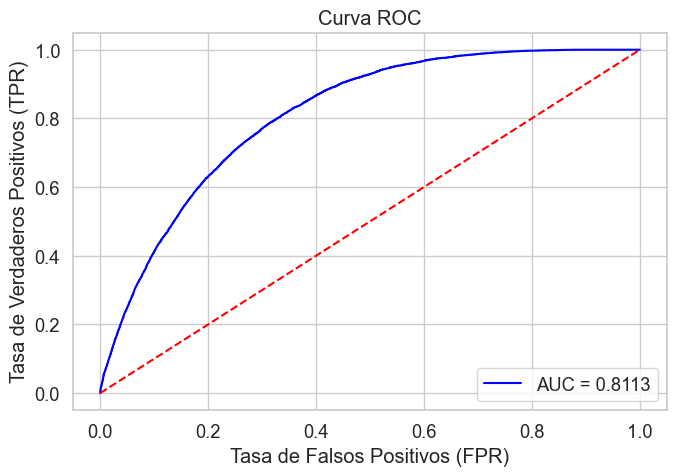

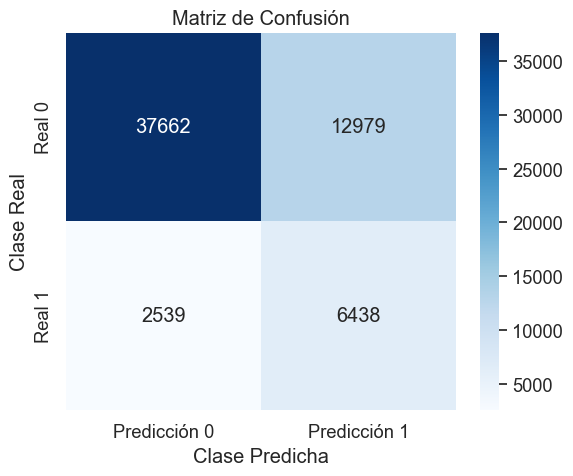

In [18]:
# -----------------------------------------------------
# 4. Generar los Gráficos
# -----------------------------------------------------
# Configuración general de los gráficos
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# a) Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# b) Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicción 0', 'Predicción 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.title('Matriz de Confusión')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()

## **CONCLUSIONES**
El modelo ha mostrado una mejora considerable en los resultados. Esto se refleja claramente en la matriz de confusión, donde se observa que el modelo predice correctamente aproximadamente el 33% de las operaciones positivas. Es importante destacar que, aunque el modelo solo ha sido entrenado con una cuarta parte de los datos, ha demostrado la capacidad de realizar predicciones precisas sobre el dataset completo. En la arquitectura del modelo, nos hemos enfocado en prevenir el sobreajuste.

Hasta el momento, hemos logrado un modelo con las siguientes características:

| Métrica                     | Puntuación | Explicación |
|-----------------------------|------------|-------------|
| **Precisión (Precision)**   | 0.331565   | Esto significa que el 33.16% de las predicciones etiquetadas como positivas realmente corresponden a operaciones positivas. |

La precisión es una de las métricas más importantes en este contexto, ya que indica que el modelo tiene una tasa de acierto del 33%. Dada la complejidad del mercado, esta tasa de acierto es un buen punto de partida para seguir optimizando el modelo.

### Conceptos clave en el desarrollo del modelo

A continuación, se describen algunos de los conceptos y técnicas utilizados en el desarrollo del modelo de machine learning:

- **Balance de clases**: Se implementó para asegurar que el modelo no estuviera sesgado hacia ninguna de las clases, dado que trabajamos con datos desbalanceados.
    - Submuestreo (Undersampling)
    - Sobremuestreo (Oversampling)
- **Dropout**: Técnica utilizada para prevenir el sobreajuste (overfitting), haciendo que el modelo sea más robusto.
- **Batch Normalization**: Ayuda a mejorar la eficiencia del entrenamiento normalizando las entradas de cada capa, permitiendo que el modelo se entrene más rápido y de manera más estable.
- **Compute_class_weight**: Esta función se utilizó para calcular el peso de las clases, lo que contribuye a lidiar con el desbalance de clases, ajustando el impacto de cada clase en la función de pérdida.
- **Redes neuronales recurrentes (RNN)**: Estas redes fueron implementadas para aprovechar la secuencialidad de los datos.
- **Redes neuronales densas (DNN) o Fully Connected Networks (FCN)**: Redes neuronales donde cada neurona de una capa está completamente conectada a todas las neuronas de la siguiente capa, lo que mejora la capacidad de representación del modelo.
- **Métricas de evaluación**: Se utilizaron diversas métricas de evaluación para monitorear y optimizar el rendimiento del modelo.

Con estos elementos, hemos establecido una base sólida para seguir mejorando el rendimiento del modelo en futuras iteraciones.


